In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=5, worker_memory=4, master_memory=4)

spark.cores.max,20
spark.ui.port,4190
spark.executor.instances,4
spark.dynamicAllocation.enabled,false
spark.sql.warehouse.dir,file:/users/home/mda205/DATA420%20Assignment%202/spark-warehouse
spark.driver.memory,4g
spark.executor.cores,5
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.sql.shuffle.partitions,80


In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

import json
import numpy as np

from pretty import SparkPretty  # download pretty.py from LEARN and put it in your M:\ or home directory
pretty = SparkPretty(limit=5)

import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib notebook

from pyspark_dist_explore import hist
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

import seaborn as sns

In [4]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')
    
    
# Other imports to be used locally

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

# %matplotlib notebook
# mpl notebook makes me want to scream my plots get messed up EVERY time

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])


# Helper functions

def evaluate_metrics_and_cost_local(pred_local, threshold, FP_cost, FN_cost, labelCol="label", predictionCol="customPrediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    pred_local[predictionCol] = (pred_local[probabilityCol].apply(lambda x: x[1]) > threshold).astype(int)

    total = pred_local.shape[0]

    nP_actual = (pred_local[labelCol] == 1).sum()
    nN_actual = (pred_local[labelCol] == 0).sum()

    nP = ((pred_local[predictionCol] == 1)).sum()
    nN = ((pred_local[predictionCol] == 0)).sum()
    TP = ((pred_local[predictionCol] == 1) & (pred_local[labelCol] == 1)).sum()
    FP = ((pred_local[predictionCol] == 1) & (pred_local[labelCol] == 0)).sum()
    FN = ((pred_local[predictionCol] == 0) & (pred_local[labelCol] == 1)).sum()
    TN = ((pred_local[predictionCol] == 0) & (pred_local[labelCol] == 0)).sum()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    cost_total = FP_cost * FP + FN_cost * FN

    return precision, recall, accuracy, cost_total

In [5]:
# Dataset names and attribute type mapping

attributes_path = 'hdfs:///data/msd/audio/attributes/'

hadoop = sc._jvm.org.apache.hadoop
fs = hadoop.fs.FileSystem
conf = hadoop.conf.Configuration()
path = hadoop.fs.Path(attributes_path)
getfile=fs.get(conf).listStatus(path)

datasets=[]
modified_filenames=[]

for f in getfile:
    
    filename = f.getPath().getName()
    datasets.append(filename[:-15])
    
    mod_filename = filename.replace("-","_")
    modified_filenames.append(mod_filename[:-17])
    

lookup = {
    'real': DoubleType(),
    'NUMERIC': DoubleType(),
    'float': DoubleType(),
    'string': StringType(),
    'STRING': StringType(),
}


# Choose a dataset name, load attribute names, and define schemas based on attribute names
def SingleDataset(dataname):

    name = f'{dataname}'

    metadata_schema = StructType([
        StructField("name", StringType()),
        StructField("type", StringType())])

    metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv', schema=metadata_schema)

    schema_actual = StructType([
        StructField(name, lookup[typename], True) for name, typename in metadata.collect()])

    SingleData = spark.read.csv(f'/data/msd/audio/features/{name}.csv', 
                                schema=schema_actual, quote="'").withColumnRenamed(schema_actual[-1].name, "track_id")
    
    def DFCounts(name, df):
        print(name+" has:")
        print(f"{len(df.columns)} columns")
        print(f"{df.count()} rows")
        df=df.select((F.countDistinct("track_id")).alias("total unique songs"))
        df.show()
    
    counts = lambda : DFCounts(name, SingleData)
    
    return SingleData, counts

# Audio Similarity

## Q1
### Q1a

In [6]:
data, datacounts=SingleDataset("msd-jmir-methods-of-moments-all-v1.0") 
#i just want to have datacounts to use later. need datacounts() to print

In [7]:
# the long titles were driving me mad so I did this to abbreviate them
# i did have to manually check the col names to assign these correctly

for i in range(len(data.columns[:-1])):
    
    if i<=4:
        
        x=i+1
        data=data.withColumnRenamed(data.columns[i], f'MoM_St_Dev_{x}')
        
        x=0
    if i>4:
        
        x=x+1
        data=data.withColumnRenamed(data.columns[i], f'MoM_Avg_{x}')

descriptive statistics

In [8]:
data_filtered = (
    data.filter(F.col('track_id')
                   .isNotNull()).dropDuplicates(subset=['track_id']))


show_as_html(data_filtered.describe())
show_as_html(data_filtered.summary())

,summary,MoM_St_Dev_1,MoM_St_Dev_2,MoM_St_Dev_3,MoM_St_Dev_4,MoM_St_Dev_5,MoM_Avg_1,MoM_Avg_2,MoM_Avg_3,MoM_Avg_4,MoM_Avg_5,track_id
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,0.1549817600174638,10.384550576952277,526.8139724398088,35071.97543290272,5297870.369577217,0.35084444325313224,27.46386798784061,1495.809181207553,143165.46163257837,2.396783048473542E7,None
2,stddev,0.06646213086143024,3.8680013938746765,180.43775499775242,12806.816272955564,2089356.4364558007,0.18557956834383837,8.352648595163757,505.8937639190225,50494.27617103219,9307340.299219683,None
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-146300.0,0.0,TRAAAAK128F9318786
4,max,0.959,55.42,2919.0,407100.0,4.657E7,2.647,117.0,5834.0,452500.0,9.477E7,TRZZZZO128F428E2D4


,summary,MoM_St_Dev_1,MoM_St_Dev_2,MoM_St_Dev_3,MoM_St_Dev_4,MoM_St_Dev_5,MoM_Avg_1,MoM_Avg_2,MoM_Avg_3,MoM_Avg_4,MoM_Avg_5,track_id
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,0.1549817600174638,10.384550576952268,526.8139724398089,35071.97543290272,5297870.369577217,0.3508444432531321,27.463867987840615,1495.809181207553,143165.46163257837,2.396783048473542E7,None
2,stddev,0.06646213086143023,3.868001393874678,180.43775499775248,12806.816272955564,2089356.4364557997,0.18557956834383837,8.352648595163759,505.89376391902255,50494.27617103218,9307340.299219687,None
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-146300.0,0.0,TRAAAAK128F9318786
4,25%,0.1058,7.704,403.5,26170.0,3845000.0,0.2081,21.71,1151.0,101800.0,1.659E7,None
5,50%,0.1524,9.955,515.1,34200.0,5042000.0,0.3293,27.92,1549.0,159300.0,2.736E7,None
6,75%,0.1991,12.66,632.8,42490.0,6383000.0,0.4727,33.28,1872.0,184300.0,3.115E7,None
7,max,0.959,55.42,2919.0,407100.0,4.657E7,2.647,117.0,5834.0,452500.0,9.477E7,TRZZZZO128F428E2D4


checking for correlation

In [9]:
# Explore correlations before we select what we need

assembler = VectorAssembler(
    inputCols=[col for col in data_filtered.columns if col.startswith("M")],
    outputCol="features"
)

vector_data = assembler.transform(data_filtered)

# show_as_html(vector_data)

correlations = Correlation.corr(vector_data, 'features', 'pearson').collect()[0][0].toArray()  # from Spark's output to numpy array


In [10]:
# standardize the nutty numbers

standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='scale_features')

model = standardizer.fit(vector_data)
std_data = model.transform(vector_data)

correlations = Correlation.corr(std_data, 'features', 'pearson').collect()[0][0].toArray()  # from Spark's output to numpy array

In [11]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(HTML(pd.DataFrame(correlations.round(2)).to_html(max_cols=30)))
display(HTML(pd.DataFrame(correlations > threshold).astype(int).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.43,0.30,0.06,-0.06,0.75,0.50,0.45,0.17,0.10
1,0.43,1.00,0.86,0.61,0.43,0.03,0.41,0.40,0.02,-0.04
2,0.30,0.86,1.00,0.80,0.68,-0.08,0.13,0.18,-0.09,-0.14
3,0.06,0.61,0.80,1.00,0.94,-0.33,-0.22,-0.16,-0.25,-0.22
4,-0.06,0.43,0.68,0.94,1.00,-0.39,-0.36,-0.29,-0.26,-0.21
5,0.75,0.03,-0.08,-0.33,-0.39,1.00,0.55,0.52,0.35,0.28
6,0.50,0.41,0.13,-0.22,-0.36,0.55,1.00,0.90,0.52,0.42
7,0.45,0.40,0.18,-0.16,-0.29,0.52,0.90,1.00,0.77,0.69
8,0.17,0.02,-0.09,-0.25,-0.26,0.35,0.52,0.77,1.00,0.98
9,0.10,-0.04,-0.14,-0.22,-0.21,0.28,0.42,0.69,0.98,1.00


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,0,0,0,0,1,1


## Q1 b
genres and genre distribution

In [12]:
# Load data from HDFS
genres_schema = StructType([
    StructField("track_id", StringType()),
    StructField("genre", StringType()),
])

genres = (
  spark.read.format("com.databricks.spark.csv")    
    .option("delimiter", "\t")
    .option("inferSchema", "false")
    .option("header", "false")
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv", schema=genres_schema)
)

In [13]:
counts=(genres.groupby("genre")
        .agg(F.count(F.col("genre")).alias("genre_count"))
        .withColumn("genreIndex", 
                    F.row_number().over(Window.orderBy((F.col("genre_count").desc())))))

pdCounts=counts.toPandas()

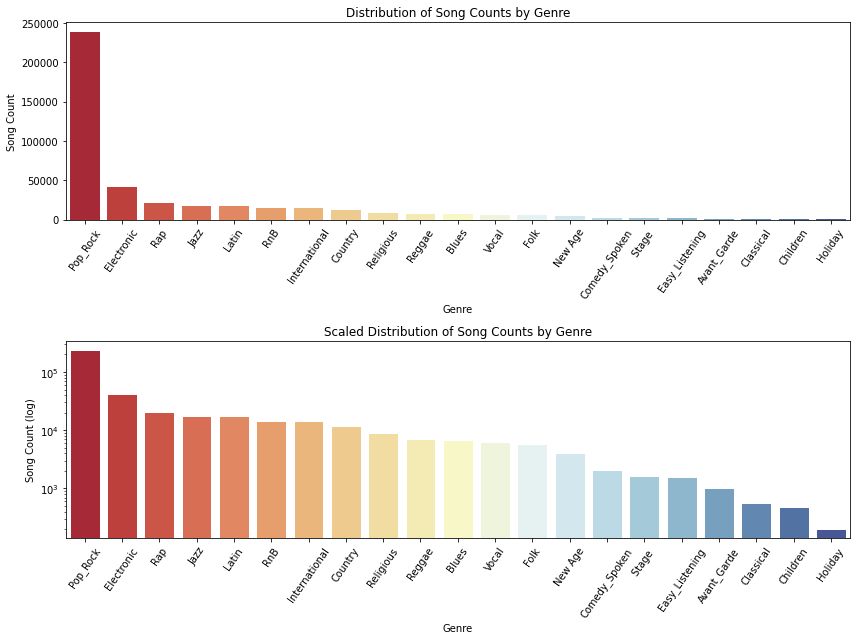

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1,  figsize=(12, 9))
color='RdYlBu'

# not log-scale -- i love a good hot to cold color scheme 
sns.barplot(x='genre', y='genre_count', data=pdCounts, palette=color, ax=ax1)
sns.set_style('whitegrid')
ax1.set_ylabel('Song Count')
ax1.set_title('Distribution of Song Counts by Genre')
ax1.set_xlabel("Genre")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=55)

# log-scale
sns.barplot(x='genre', y='genre_count', data=pdCounts, palette=color, ax=ax2)
sns.set_style('whitegrid')
ax2.set_yscale('log')
ax2.set_xlabel('Genre')
ax2.set_ylabel('Song Count (log)')
ax2.set_title("Scaled Distribution of Song Counts by Genre")

plt.xticks(rotation=55)
plt.tight_layout()
plt.show()


## Q1c

In [15]:
dataset_genres=data_filtered.join(genres, on="track_id", how="left")
dataset_genres=dataset_genres.where(F.col("genre").isNotNull())

# sticking counts on here because, well, i'm redoing this and know i need the indexers and rather than 
# re-vectorize everything again for multi-class using index
dataset_genres_indexed=dataset_genres.join(counts, on="genre", how="left")

# Q2
Binary Classification

### Q2b

In [16]:
# make binary label for electronic or not electronic

def is_electronic(genre):
    if genre=="Electronic":
        return 1
    else: 
        return 0


is_electronic_udf = F.udf(is_electronic, IntegerType())

# ------
binary_data_indexed = dataset_genres_indexed.withColumn("label",
    is_electronic_udf(F.col('genre')))



# vector assemble for the models
assembler = VectorAssembler(
    inputCols=[col for col in binary_data_indexed.columns if col.startswith("M")],
    outputCol="vect_features"
)


vectordata = assembler.transform(binary_data_indexed)
vectordata = vectordata.select(
    F.col('track_id'),
    F.col('label'),
    F.col("genreIndex"),
    F.col('vect_features').alias("features"),
)

# standardize the nutty numbers

standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='scaled_features')

model = standardizer.fit(vectordata)
std_binary = model.transform(vectordata)

# replacing features with the scaled version 
std_binary=std_binary.drop(F.col("features")).withColumnRenamed("scaled_features", "features")

# std_binary.show()
print_class_balance(std_binary, "genre")

dataset: genre
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319



### Q2c

In [17]:
# Exact stratification using Window (binary, counts hard coded)

temp = (
    std_binary
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379954 * 0.8)) |  # not_El_actual = 379954
    ((F.col("label") == 1) & (F.col("row") < 40666    * 0.8))    # El_actual = 40666
)
training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(std_binary, "data")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: data
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

dataset: test
total:   84125
counts:
   label  count     ratio
0      1   8134  0.096689
1      0  75991  0.903311



## Q2d - train the models


https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

#### Logistic Regression Model: 

In [18]:
# No sampling

print_class_balance(training, "training")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training)
lr_pred = lr_model.transform(test)
lr_pred.cache()

print_metrics(lr_pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        486
nN:        83639

TP         236
FP         250
FN         7898
TN         75741

precision: 0.48559671
recall:    0.02901402
accuracy:  0.90314413

auroc:     0.76061495



#### Random Forest

In [19]:
print_class_balance(training, "training")

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(training)
rf_pred = rfModel.transform(test)
rf_pred.cache()

print_metrics(rf_pred)

# so thats a no on this one

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        0
nN:        84125

TP         0
FP         0
FN         8134
TN         75991

precision: 0.00000000
recall:    0.00000000
accuracy:  0.90331055

auroc:     0.74290820



#### Gradient Boosted Tree

In [20]:
print_class_balance(training, "training")

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(training)
gbt_pred = gbtModel.transform(test)
gbt_pred.cache()

print_metrics(gbt_pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1509
nN:        82616

TP         877
FP         632
FN         7257
TN         75359

precision: 0.58117959
recall:    0.10781903
accuracy:  0.90622288

auroc:     0.79507711



## Q3 a



In [21]:
# towards data science showed this method to explain the parameters of the model

print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

in the wise wise words of Hazel, "maxDepth, MaxIter and maxBins are the only things that you'll really need to fiddle with" and frankly I don't think i have enough confidence in wtf im doing to change anything else beyond what she, and towards data science suggest


maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)

### Q3b - cross validation

In [22]:
evaluator = BinaryClassificationEvaluator()

print_class_balance(training, "training")

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)


cvModel = cv.fit(training)
pred = cvModel.transform(test)

print_metrics(pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1749
nN:        82376

TP         1059
FP         690
FN         7075
TN         75301

precision: 0.60548885
recall:    0.13019425
accuracy:  0.90769688

auroc:     0.80977124



# Q4
### Q4a


the question is predominantly an "answer on word doc question"

### Q4b

i already added an "index" column on "counts" based on popularity (the benefits of re-doing things)

In [23]:
MultiClass_Genres=std_binary.drop(F.col("label")).withColumnRenamed("genreIndex", "label")
# MultiClass_Genres.show()

### Q4c

In [24]:
def MultiClass_TrainTestSplit(data):
    
    temp = (
        data
        .withColumn("id", F.monotonically_increasing_id())
        .withColumn("random", F.rand())  # random number between 0 and 1
        .withColumn(
            "row",
            F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
            .over(
                Window
                .partitionBy("label")
                .orderBy("random")
            )
        )
    )

    counts = (
        data
        .groupBy("label")
        .count()
        .toPandas()
        .set_index("label")["count"]
        .to_dict()
    )
    labels = sorted(counts.keys())

    multi_training = temp
    for label in labels:
        multi_training = multi_training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

    multi_training.cache()

    multi_test = temp.join(multi_training, on="id", how="left_anti")
    multi_test.cache()

    multi_training = multi_training.drop("id", "random", "row")
    multi_test = multi_test.drop("id", "random", "row")

    print_class_balance(data, "multiclass data")
    print_class_balance(multi_training, "multiclass training")
    print_class_balance(multi_test, "multiclass test")
    
    return multi_training, multi_test

In [25]:
multi_training, multi_test = MultiClass_TrainTestSplit(MultiClass_Genres)

dataset: multiclass data
total:   420620
counts:
    label   count     ratio
0      10    6931  0.016478
1       1  237649  0.564997
2      13    5789  0.013763
3      14    4000  0.009510
4       6   14314  0.034031
5      17    1535  0.003649
6       9    8780  0.020874
7       7   14194  0.033745
8      19     555  0.001319
9      18    1012  0.002406
10     11    6801  0.016169
11     16    1613  0.003835
12      3   20899  0.049686
13     20     463  0.001101
14      2   40666  0.096681
15      4   17775  0.042259
16      8   11691  0.027795
17     21     200  0.000475
18     12    6182  0.014697
19      5   17504  0.041615
20     15    2067  0.004914

dataset: multiclass training
total:   336483
counts:
    label   count     ratio
0      10    5544  0.016476
1       1  190119  0.565018
2      13    4631  0.013763
3      14    3199  0.009507
4       6   11451  0.034031
5       9    7023  0.020872
6      17    1227  0.003647
7       7   11355  0.033746
8      19     443  0.001317
9

In [26]:
# yeehaw for blindly trusting chatgpt on this one

def print_multi_metrics(pred, test):

    predictions = pred.select('prediction').rdd.map(lambda row: row[0])
    labels = test.select(F.col('label').cast('double')).rdd.map(lambda row: row[0])

    # Create an instance of MulticlassMetrics
    metrics = MulticlassMetrics(predictions.zip(labels))

    # Overall accuracy
    print("Accuracy:", metrics.accuracy)

    # Precision by label
    labels = sorted(labels.distinct().collect())
    for label in labels:
        print(f"Precision (label {label}):", metrics.precision(label))

    # Recall by label
    for label in labels:
        print(f"Recall (label {label}):", metrics.recall(label))

    # F1-Score by label
    for label in labels:
        print(f"F1-Score (label {label}):", metrics.fMeasure(label))

In [27]:
# and a greater yeehaw for your sample notebooks

def resampling(training, upper, lower):
    # Counts for upsampling / downsampling

    counts = {
        label: count for label, count in training.groupBy("label").count().collect()}

    # Upsampling via poisson random sampling

    count_lower_bound = upper
    count_upper_bound = lower

    def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

        count = counts[x]

        if count < count_lower_bound:
            return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

        if count > count_upper_bound:
            if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
                return [1]
            else:
                return []

        return [1]  # do nothing

    random_resample_udf = F.udf(
        lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
        ArrayType(IntegerType())
    )
    training_resampled = (
        training
        .withColumn("rand", F.rand())
        .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
        .select(
            F.col("track_id"),
            F.col("label"),
            F.col("features"),
            F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
        )
        .drop("sample"))
    
    print_class_balance(training_resampled, 'training (resampled)')
    
    return training_resampled



def MultiClass_LogisticReg(training, test, sampletype=""):
    
    multi_lr = LogisticRegression(featuresCol='features', labelCol='label')
    
    multi_lr_model = multi_lr.fit(training)
    multi_lr_pred = multi_lr_model.transform(test)
    multi_lr_pred.cache()

    multiclass_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    print_class_balance(multi_lr_pred, f'{sampletype} logistic regression model')
    print(f'Logistic Regression AUROC: {multiclass_evaluator.evaluate(multi_lr_pred)}')
    print_multi_metrics(multi_lr_pred, test)
    
    return multi_lr_pred


### Multiclass Logistic Regression

In [28]:
lr_training_resampled=resampling(multi_training, 5000, 5000)

multi_lr_pred=MultiClass_LogisticReg(lr_training_resampled, multi_test, "resampled")

dataset: training (resampled)
total:   105076
counts:
    label  count     ratio
0      10   5022  0.047794
1       1   4917  0.046795
2      13   4975  0.047347
3      14   5033  0.047899
4       6   5079  0.048336
5       9   5040  0.047965
6      17   4986  0.047451
7       7   4969  0.047290
8      19   4980  0.047394
9      18   5006  0.047642
10     11   5001  0.047594
11     16   4889  0.046528
12      3   4898  0.046614
13     20   4975  0.047347
14      2   5021  0.047784
15      4   5012  0.047699
16      8   5021  0.047784
17     21   4984  0.047432
18     12   4994  0.047528
19      5   4943  0.047042
20     15   4979  0.047385

dataset: resampled logistic regression model
total:   84137
counts:
    label  count     ratio
0      10   1387  0.016485
1       1  47530  0.564912
2      14    801  0.009520
3      13   1158  0.013763
4       9   1757  0.020883
5       6   2863  0.034028
6      17    308  0.003661
7       7   2839  0.033743
8      19    112  0.001331
9      18    

The metrics look absurd to print, and garbage numbers, but it seems better to me to at least HAVE a number for each genre?

but honestly like i HARDLY know or understand stats so  uhhhh please be nice on my statistical intepretations cause i have no clue what i'm doing lol like honestly i get it all in theory and principal but man i got myself confused so many times, which is also why i really dont have a lot of markdown comments which i know i'm supposed to have. also....no maps for the geoscientist on this one :(

In [29]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()